# Visualizations

## Inputs

- `models/1_connectivity_classifier_results.nc`: results from the connectivity classifier notebook.

## Outputs

- Figure 2: model performance + brain networks
- Figure 3: feature importance
- Figure 4: robustness of feature importance
- Figure 5: misclassified subjects

## Requirements

In addition to the requirements in [1 Connectivity Classifier.ipynb](1 Connectivity Classifier.ipynb), you need to install the following packages:

```bash
mamba activate acnets
mamba install seaborn
pip install statannotations

```

## Analysis

In [360]:
# SETUP

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import xarray as xr
from sklearn.model_selection import StratifiedShuffleSplit

import shap

sns.set('paper', style='whitegrid')

In [361]:
results = xr.open_dataset('models/1_connectivity_classifier_results_cv8.nc').load()

In [362]:
import re
split_score_cols = [c for c in list(results.keys()) if re.match(r'split\d+_test_score', c)]
grid_cv_results = results[split_score_cols + ['rank_test_score', 'mean_test_score']].to_pandas()
grid_cv_results.index.name = 'label'
grid_cv_results = grid_cv_results.reset_index()

In [363]:
results

<xarray.Dataset>
Dimensions:                                         (
                                                     gordon2014_2mm_feature: 91,
                                                     subject: 32, shap_dim: 24,
                                                     dosenbach2010_feature: 21,
                                                     permutation_importance_num: 15,
                                                     grid_model_name: 15,
                                                     learning_curve_num: 5,
                                                     model_name: 3, cv_dim: 3,
                                                     permutation_dim: 2,
                                                     y_classes: 2)
Coordinates:
  * gordon2014_2mm_feature                          (gordon2014_2mm_feature) object ...
  * dosenbach2010_feature                           (dosenbach2010_feature) object ...
  * grid_model_name                                 (grid_model_name) object ...
  * learning_curve_num                              (learning_curve_num) int32 ...
  * model_name                                      (model_name) object 'gord...
  * y_classes                                       (y_classes) object 'AVGP'...
Dimensions without coordinates: subject, shap_dim, permutation_importance_num,
                                cv_dim, permutation_dim
Data variables: (12/39)
    X                                               (subject) object 'AVGP01'...
    y                                               (subject) object 'AVGP' ....
    gordon2014_2mm partial correlation shap         (shap_dim, gordon2014_2mm_feature) float64 ...
    gordon2014_2mm partial correlation shap data    (shap_dim, gordon2014_2mm_feature) float64 ...
    dosenbach2010 tangent shap                      (shap_dim, dosenbach2010_feature) float64 ...
    dosenbach2010 tangent shap data                 (shap_dim, dosenbach2010_feature) float64 ...
    ...                                              ...
    cv_scores                                       (model_name, cv_dim) float64 ...
    perm_scores                                     (model_name, permutation_dim) float64 ...
    pvalue                                          (model_name) float64 0.66...
    cv_test_size                                    int32 8
    cv_n_splits                                     int32 3
    n_subjects                                      int32 32

In [364]:
ATLAS = 'dosenbach2010'
KIND = 'precision'
MODEL_NAME = f'{ATLAS} {KIND}'


n_subjects = results['n_subjects'].item()
X = results['X'].values
y = results['y'].values
y_encoder = LabelEncoder().fit(y)
cv_test_size = results['cv_test_size'].item()
cv_n_splits = results['cv_n_splits'].item()
scoring = results['scoring'].item()
cv = StratifiedShuffleSplit(n_splits=cv_n_splits, test_size=cv_test_size)
perm_scores = results.sel(model_name=MODEL_NAME)['perm_scores'].values
perm_obs_scores = results.sel(model_name=MODEL_NAME)['cv_scores'].values
perm_pvalue = results.sel(model_name=MODEL_NAME)['pvalue'].item()
# perm_imp_scores = results[f'{MODEL_NAME} importances'].to_pandas()
shap_values = results[f'{MODEL_NAME} shap'].values
shap_importances = results[f'{MODEL_NAME} shap'].to_pandas().mean().reset_index()
shap_importances.columns = ['feature_name', 'shap']
shap_data = results[f'{MODEL_NAME} shap data'].values
shap_y_pred = results[f'{MODEL_NAME} shap y_pred'].values
shap_y_test = results[f'{MODEL_NAME} shap y_test'].values
feature_names = results[f'{ATLAS}_feature'].values

shap_values = shap.Explanation(
    values=shap_values,
    data=shap_data,
    feature_names=feature_names,
    output_indexes=y_encoder.transform(shap_y_pred),
    output_names=y_encoder.classes_
)

In [365]:
%%script echo skipping...

# PLOT MODEL PERFORMANCE

def _create_label(params):
    return f'$\\bf{{{params[0]}}}$\n{params[1]}'.replace('_2mm', '').replace('_','\\_')

sns.set('paper', 'ticks')

# prep data
scores = grid_cv_results
# scores['label'] = scores['params'].apply(lambda p: _create_label(list(p.values())))
split_score_cols = [c for c in scores.columns if 'split' in c]
scores['cv_test_score'] = scores[split_score_cols].apply(lambda x: list(x), axis=1)
scores = scores.explode('cv_test_score').reset_index(drop=True)
scores = scores.sort_values('rank_test_score', ascending=False)

_, ax = plt.subplots(figsize=(len(results['grid_model_name']) * 1.1, 5))

# score curve + CI
sns.lineplot(data=scores, x='label', y='cv_test_score', lw=3, sort=False, ax=ax)

# blue dots
sns.scatterplot(data=scores, x='label', y='mean_test_score', marker='o', s=100, ax=ax, label='_nolegend_')

# simulate and plot chance
chance_scores = {}
for model_name in scores['label'].unique():
    chance_model = DummyClassifier(strategy='stratified').fit(X, y)
    _chance_scores = cross_val_score(chance_model, X, y, cv=cv, scoring=scoring)
    chance_scores[model_name] = _chance_scores

chance_scores = pd.DataFrame(chance_scores)
chance_scores = chance_scores.melt(value_name=scoring, var_name='label')

# plot chance
sns.lineplot(data=chance_scores, x='label', y=scoring, lw=2, sort=False, ax=ax, color='red')

# legend
ax.legend(['average', '95% CI', 'chance'],
            title_fontproperties={'weight': 'bold', 'size': 'x-large'},
            prop={'size': 'x-large'}, loc='upper left',
            title=f'{cv.n_splits} $\\times$ {n_subjects // cv.test_size}-fold CV')

# tweaks
ax.set_xlabel('')
ax.set_ylabel(scoring, fontsize='xx-large')
plt.xticks(rotation=45, ha='right', fontsize='x-large', rotation_mode='anchor')
plt.suptitle(f'classification {scoring} (validation set)', fontsize='xx-large', y=.95)
plt.grid(axis='y')

plt.show()

skipping...


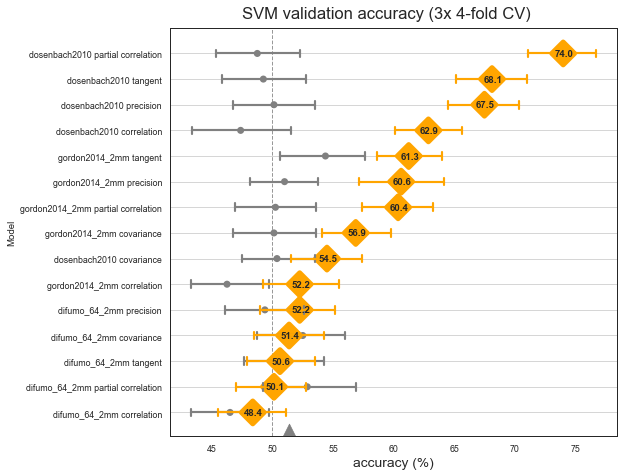

In [366]:
sns.set('paper', 'white')
_, ax = plt.subplots(figsize=(8, len(results['grid_model_name']) * .5))

def jitter(df, column='cv_test_score', jitter_size=.03):
    jittered_df = df.copy()
    jittered_df[column] = jittered_df[column] + np.random.uniform(-jitter_size, jitter_size, len(df))
    return jittered_df    

scores = scores.sort_values('mean_test_score', ascending=True)
order = scores['label'].drop_duplicates()
mean_scores = scores.groupby('label')[['cv_test_score']].mean().reset_index()


scores['accuracy_pct'] = scores['cv_test_score'] * 100.0
chance_scores['accuracy_pct'] = chance_scores['accuracy'] * 100.0
mean_scores['accuracy_pct'] = mean_scores['cv_test_score'] * 100.0

# chance
g = sns.pointplot(data=chance_scores,
              x='accuracy_pct', y='label', order=order,
              join=False,
            #   markers='D',
              color='gray',
              capsize=0.3,
              cmap='viridis',
              size=5, ax=ax,
              label='chance')
# plt.setp(g.collections, alpha=.3) # alpha the markers
# plt.setp(g.lines, alpha=.3) # alpha the lines

# observation
sns.pointplot(data=scores,
              x='accuracy_pct', y='label', order=order,
              join=False,
              color='orange',
              markers='D',
              capsize=0.3,
              scale=3,
              cmap='viridis',
              plot_kws=dict(zorder=1),
              ax=ax,
              label='observation')

# annotate the mean points
y_ticklabels = [t.get_text() for t in ax.get_yticklabels()]
for i, model_name, cv_test_score, accuracy_pct in mean_scores.itertuples():
    y = y_ticklabels.index(model_name)
    ax.annotate(f'{accuracy_pct:.1f}', (accuracy_pct-.7, y-0.1), weight='bold')

ax.grid(axis='y')

ax.axvline(x=50, linestyle='--', color='gray', linewidth=1, alpha=.8, label='theoretical chance', zorder=-1)

ax.scatter([51.4], [-.7], marker='^', s=160, color='gray')

ax.set(ylabel='Model', ylim=(-.9, len(order)))
ax.set_xlabel('accuracy (%)', fontsize='x-large')

# plt.legend().set_visible(False)
# plt.legend()



plt.suptitle(f'SVM validation accuracy ({cv_n_splits}x 4-fold CV)', fontsize='xx-large', y=.92)
plt.show()

In [367]:
%%script echo skipping...

# SIGNIFICANCE TESTING

scores = grid_cv_results
# scores['label'] = scores['params'].apply(lambda p: ' '.join(p.values()))
split_score_cols = [c for c in scores.columns if 'split' in c]
scores['cv_test_score'] = scores[split_score_cols].apply(lambda x: list(x), axis=1)
scores = scores.explode('cv_test_score').reset_index(drop=True)
scores = scores.sort_values('rank_test_score', ascending=False)

chance_model = DummyClassifier(strategy='stratified')
chance_scores = cross_val_score(chance_model, X, y, cv=cv, scoring=scoring)

# visible_labels = ['chance','dosenbach2010 tangent', 'dosenbach2010 precision', 'dosenbach2010'
#        'dosenbach2010 partial correlation']

# scores = scores.query('label in @visible_labels')


scores = pd.concat([pd.DataFrame({
    'cv_test_score': chance_scores,
    'label': '$\\bf{chance}$'
}), scores]).reset_index()

_, ax = plt.subplots(figsize=(8, 5))


sns.set('paper', style='white')
g = sns.barplot(data=scores[::-1], y='label', x='cv_test_score', orient='h', ci=95, capsize=.3, ax=ax, palette='RdBu_r')
ax.set_xlabel(scoring, fontsize='x-large')
ax.set_yticklabels(ax.get_yticklabels(), fontsize='x-large')

ax.set_ylabel('atlas and connectivity', fontsize='x-large', labelpad=20)


from statannotations.Annotator import Annotator

annotator = Annotator(g, [("dosenbach2010 partial correlation", '$\\bf{chance}$')], data=scores, y='label', x='cv_test_score', orient='h')
annotator.configure(test='t-test_ind', text_format='star', loc='inside',)
annotator.apply_and_annotate()


plt.show()


skipping...


In [368]:
%%script echo skipping...

# PLOTS
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

g = sns.FacetGrid(scores, row="label", hue="label", aspect=12, height=.5)

# Draw the densities in a few steps
g.map(sns.kdeplot, "cv_test_score",fill=True, alpha=1, linewidth=1)
g.map(sns.kdeplot, "cv_test_score", color="w", lw=1.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=1, linestyle="-", color=None, clip_on=False)

import matplotlib.patheffects as PathEffects

def label(x, color, label):
    ax = plt.gca()
    txt = ax.text(0, .2, label.replace('_2mm',''), color=color, weight='bold', fontsize=10,
            ha="left", va="center", transform=ax.transAxes)
    txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])


g.map(label, "label")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.2)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='', xlabel=scoring, xlim=(0, 1))
g.despine(bottom=True, left=True)

# g.figure.gca().axvline(x=0.8, color='brown', linestyle='-', linewidth=2)

plt.show()

# BOX PLOT
sns.boxplot(data=scores, x='cv_test_score', y='label', whis=0, fliersize=0, saturation=1)
sns.stripplot(x="cv_test_score", y="label", data=scores, size=4, color=".3", linewidth=0)

plt.show()

skipping...


In [369]:
%%script echo skipping...

# Now plot permuted scores along with the cross-validated scores

sns.set('paper','white')
_, ax = plt.subplots(figsize=(8,5))

# permutation scores
sns.histplot(perm_scores, ax=ax, color=(.86, .26, .46), lw=0, bins=cv_test_size, binrange=(0,1), stat='density', label='permuted labels',alpha=.7)
# sns.kdeplot(perm_scores, ax=ax, color=(.86, .26, .46), lw=2, cut=0, bw_method=.5)
ax.axvline(perm_scores.mean(), color=(.86, .26, .46), ls='--', lw=2)

# observation scores
sns.histplot(perm_obs_scores, ax=ax, color=(.11, .53, .89), lw=0, bins=cv_test_size, binrange=(0,1), stat='density',  label='observed labels', alpha=.8)
# g = sns.kdeplot(perm_obs_scores, ax=ax, color=(.11, .53, .89), lw=2, fill=True, cut=0, bw_method=.5)
ax.axvline(perm_obs_scores.mean(), color=(.11, .53, .89), ls='--', lw=2)

# tweaks
plt.xlabel('accuracy', fontsize='xx-large')
plt.ylabel('density', fontsize='xx-large')
plt.xticks(fontsize='x-large')

plt.suptitle(f'Permutation Testing (N={len(perm_scores)})', x = .31, y=.93, fontsize='xx-large')
plt.legend(loc='upper right', fontsize='x-large')

plt.text(perm_obs_scores.mean() + .01,  2.5, f'p–value={perm_pvalue:.3f}', fontsize='x-large')

plt.show()

skipping...


gordon2014_2mm partial correlation
dosenbach2010 tangent
dosenbach2010 precision


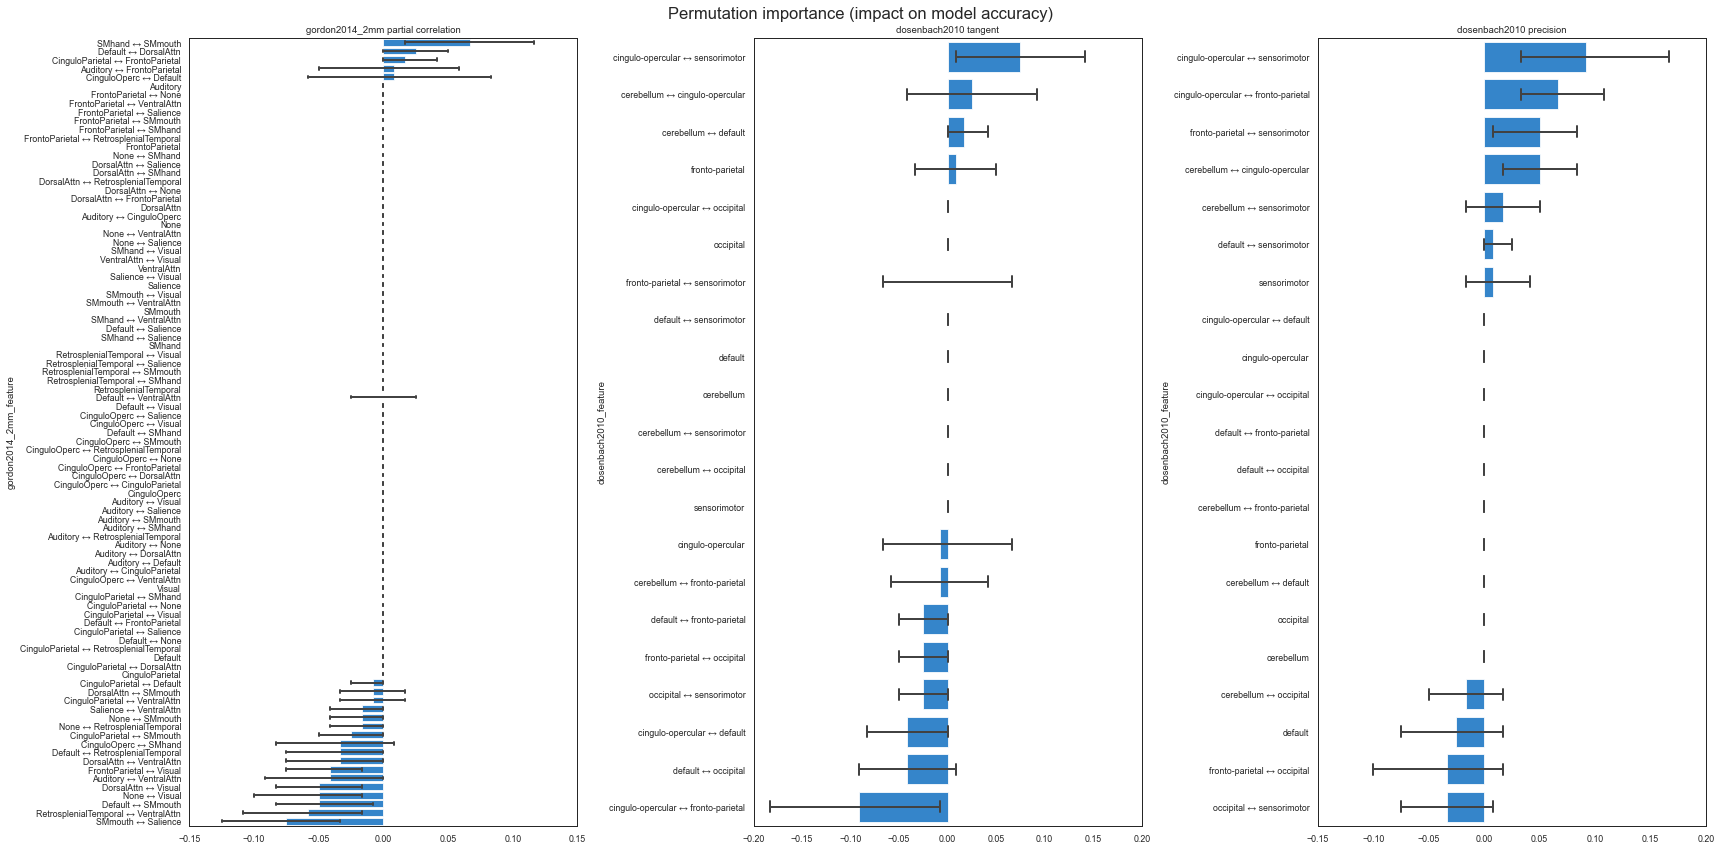

In [371]:
def plot_feature_importance(results, model_name, ax=None):

    if ax is None:
        _, ax = plt.subplots(figsize=(7, 15))

    perm_imp_scores = results[f'{model_name} importances'].to_pandas()

    perm_imp_order = perm_imp_scores.mean().sort_values(ascending=False).index.to_list()

    sns.barplot(data=perm_imp_scores,
                order=perm_imp_order,
                orient='horizontal',
                capsize=.3,
                errwidth=2,
                color=(.11, .53, .89),
                ax=ax)

    ax.set_xticks(ax.get_xticks(), fontsize='x-large')
    ax.set_yticks(ax.get_yticks(), fontsize='x-large')


model_names = results['model_name'].values

_, axes = plt.subplots(1,len(model_names),
                       figsize=(len(model_names)*8,12), sharey=False, squeeze=False)

for i, (model_name, ax) in enumerate(zip(model_names, axes.flatten())):
    plot_feature_importance(results, model_name, ax)
    ax.set(title=model_name)

plt.suptitle('Permutation importance (impact on model accuracy)', fontsize='xx-large')

plt.tight_layout()
plt.show()

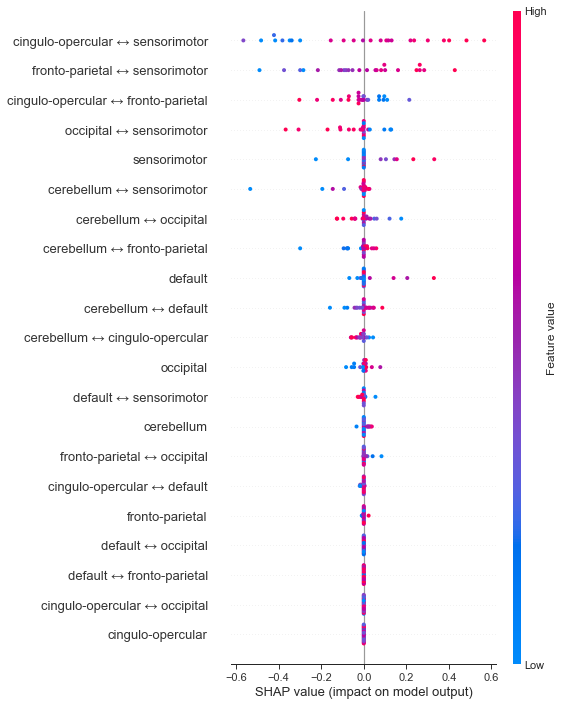

In [372]:
shap.summary_plot(shap_values,
                  feature_names=feature_names,
                  max_display=21)

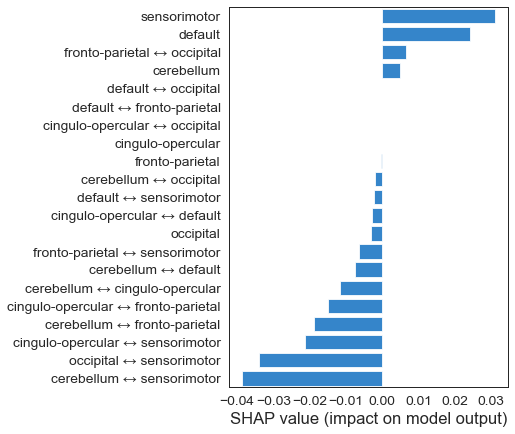

In [373]:

_, ax = plt.subplots(1,1,figsize=(5,7))
sns.barplot(data=shap_importances.sort_values('shap')[::-1],
            x='shap',
            y='feature_name',
            orient='horizontal',
            capsize=.3,
            errwidth=2,
            color=(.11, .53, .89),
            ax=ax)

plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.ylabel('')
plt.xlabel('SHAP value (impact on model output)', fontsize='xx-large')
plt.show()

FixedFormatter should only be used together with FixedLocator


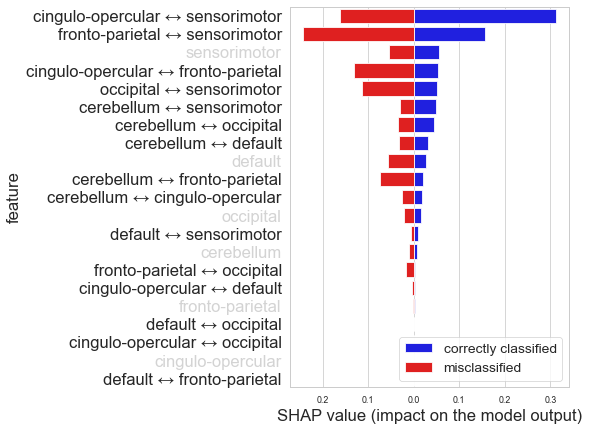

In [374]:
# DIAGNOSIS OF MISCLASSIFICATION

incorrect_pred_mask = np.where(shap_y_pred != shap_y_test)[0]     # miss classified
correct_pred_mask = np.where(shap_y_pred == shap_y_test)[0]     # correctly classified

sns.set('paper', 'whitegrid')

# DBEUG
# shap.summary_plot(shap_values.values[misclassified_mask],
#                   plot_type='bar', feature_names=feature_names)

missclassified_shaps = np.abs(shap_values.values[incorrect_pred_mask]).mean(axis=0)

plot_data = pd.DataFrame({
    'incorrect_shap': np.abs(shap_values.values[incorrect_pred_mask]).mean(axis=0),
    'correct_shap': np.abs(shap_values.values[correct_pred_mask]).mean(axis=0),
    'feature_name': feature_names
})

plot_data = plot_data.sort_values('correct_shap', ascending=False)
plot_data['incorrect_shap'] = -plot_data['incorrect_shap']

_, ax = plt.subplots(1,1,figsize=(5,7))

sns.barplot(data=plot_data, x='correct_shap', y='feature_name', color='blue', ax=ax, label='correctly classified')
sns.barplot(data=plot_data, x='incorrect_shap', y='feature_name', color='red', ax=ax, label='misclassified')

# ax.text(.05, 7.5, 'Correctly\nClassified', color='blue', fontsize='x-large', ha='left')
# ax.text(-.05, 7, 'Misclassified', color='red', fontsize='x-large', ha='right')

plt.yticks(fontsize='xx-large')
plt.legend(fontsize='x-large', loc='lower right')

for tick in ax.get_yticklabels():
    if '\N{left right arrow}' not in str(tick):
        tick.set_color('lightgray')

ax.set_xticklabels([np.round(np.abs(t), 2) for t in ax.get_xticks()])

ax.set_xlabel('SHAP value (impact on the model output)', fontsize='xx-large')
ax.set_ylabel('feature', fontsize='xx-large')

# plt.suptitle(f'SHAP values for {n_samples} correctly classified subjects sampled from all the cross-validation validation splits.\n', ha='left', x=-.3, y=.9, fontsize=14)
plt.show()